In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [ ]:
!unzip /content/drive/My\ Drive/MachineLearning/Incubator/Datasets/celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 778kB 10.5MB/s 
     |████████████████████████████████| 3.0MB 12.3MB/s 
     |████████████████████████████████| 1.1MB 43.4MB/s 
     |████████████████████████████████| 890kB 39.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.2-cp36-none-any.whl size=93964 sha256=a623f9b23cc9b7352aeacd6e1eae86effd984d0ff20384288af165eaa78be2f1
  Stored in directory: /root/.cache/pip/wheels/f7/06/a0/567f3651876165429f6510d3197b011652a25e547552816824
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=b9baa0df68f4bab2850452a4074f143fca46134b7787f0bc120a0a29efccbde8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


## Importing dependencies


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from PIL import Image
from tqdm.notebook import tqdm

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


## Using BERT sentence embeddings
(Testing BERT sentence embeddings)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens').cuda()

100%|██████████| 405M/405M [00:08<00:00, 46.4MB/s]


In [ ]:
sentences = ['The female has pretty high cheekbones and an oval face.',  'Her hair is black.',  'She has a slightly open mouth and a pointy nose.',  'The female is smiling, looks attractive and has heavy makeup.',  'She is wearing earrings and lipstick.']
sentence_embeddings = model.encode(sentences)

In [ ]:
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding.shape)
    print("")

Sentence: The female has pretty high cheekbones and an oval face.
Embedding: (768,)

Sentence: Her hair is black.
Embedding: (768,)

Sentence: She has a slightly open mouth and a pointy nose.
Embedding: (768,)

Sentence: The female is smiling, looks attractive and has heavy makeup.
Embedding: (768,)

Sentence: She is wearing earrings and lipstick.
Embedding: (768,)



In [ ]:
sentence_emb = torch.FloatTensor(sentence_embeddings).cuda()

In [ ]:
sentence_emb.shape

torch.Size([5, 768])

In [ ]:
torch.mean(sentence_emb, dim = 0).shape

torch.Size([768])

## Data Loading

In [ ]:
attributes_df = pd.read_csv('/content/drive/My Drive/MachineLearning/Incubator/Datasets/list_attr_celeba.csv')

In [ ]:
text_descr_df = pd.read_csv('/content/drive/My Drive/MachineLearning/Incubator/Datasets/text_descr_celeba.csv')

## Helper functions

In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Initialize Constants

In [ ]:
epochs = 20
output_after_every_n = 10
image_size = 64
initial_size = image_size // 16
noise_size = 100
batch_size = 64
subset_size = 10_000
num_channels = 3
dataset_len = 202599

## Balancing Dataset

In [ ]:
drop_cols = {'Bags_Under_Eyes', 'Bangs', 'Blurry', 'No_Beard'}

In [ ]:
attributes_df = attributes_df.drop(columns=drop_cols)

In [ ]:
only_attributes = attributes_df.drop(columns='image_id')

In [ ]:
classes = set(only_attributes)

In [ ]:
print('Classes present:', classes)
print('Number of classes:', len(classes))

Classes present: {'Straight_Hair', 'Chubby', 'Heavy_Makeup', 'Double_Chin', 'Bushy_Eyebrows', 'Big_Lips', 'Smiling', 'Blond_Hair', 'Gray_Hair', 'Goatee', 'Pointy_Nose', 'Rosy_Cheeks', 'Wearing_Earrings', 'Sideburns', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Arched_Eyebrows', 'Oval_Face', 'Wearing_Necktie', 'Bald', 'Attractive', '5_o_Clock_Shadow', 'Wearing_Necklace', 'Wavy_Hair', 'Black_Hair', 'Receding_Hairline', 'Brown_Hair', 'Wearing_Hat', 'Young', 'Mustache', 'Male', 'Big_Nose', 'Wearing_Lipstick', 'Narrow_Eyes', 'Pale_Skin', 'Eyeglasses'}
Number of classes: 36


## Creating Custom Dataset Class

In [ ]:
class ImageTextDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # real images
        img_name = os.path.join(self.root_dir,
                                self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        text = self.text_df.iloc[idx, 1:].values[0]

        if self.transform:
          image = self.transform(image)

        # fake images

        wrong_idx = random.randint(0, dataset_len - 1)
        while wrong_idx == idx:
          wrong_idx = random.randint(0, dataset_len - 1)
        wrong_img_name = os.path.join(self.root_dir,
                                self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
          wrong_image = self.transform(wrong_image)

        return image, text, wrong_image

In [ ]:
dataset = ImageTextDataset('/content/img_align_celeba/img_align_celeba/', '/content/drive/My Drive/MachineLearning/Incubator/Datasets/text_descr_celeba.csv', transform=transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

## Creating a subset of dataset

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random_indices = torch.randperm(subset_size)

In [ ]:
only_attributes = only_attributes.iloc[random_indices]
print('Length of subset dataset', len(only_attributes))

Length of subset dataset 10000


## Generate weights based on classes

In [ ]:
def generate_weights(arr, num_classes):
  # To get the count of each label
  counts = np.zeros(num_classes)
  for row in tqdm(arr):
    idxs = np.where(row == 1)
    counts[idxs] += 1

  # Calculating weight per class
  N = float(sum(counts))
  weight_per_class = np.zeros(num_classes)
  for i in range(num_classes):
    weight_per_class[i]  = N / counts[i]

  # Calculating final weights
  weights = [0.0] * len(arr)
  for i, row in tqdm(enumerate(arr)):
    idxs = np.where(row == 1)
    weights[i] = sum(weight_per_class[idxs])
  return weights

In [ ]:
weights = generate_weights(only_attributes.values, len(classes))

In [ ]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

## Converting to dataloader

In [ ]:
subset_dataset = torch.utils.data.Subset(dataset, random_indices)

In [ ]:
weighted_dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False, sampler=sampler, pin_memory=True)

In [ ]:
len(weighted_dataloader)

157

## Testing DataLoader output

In [ ]:
weighted_dataiter = iter(weighted_dataloader)

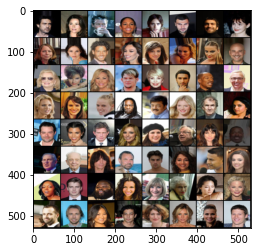

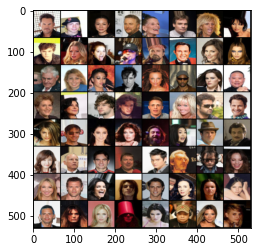

["He has a 5 o' clock shadow, has a mustache and has sideburns. His hair is black. He has a big nose, bushy eyebrows and a pointy nose. The man looks young.", 'The lady has pretty high cheekbones. Her hair is black and wavy. She has arched eyebrows and a slightly open mouth. She looks attractive, young and has heavy makeup. She is wearing lipstick and a necklace.', 'The gentleman seems young.', 'The female has a double chin and pretty high cheekbones. Her hair is black and straight. She has arched eyebrows, big lips, a big nose and a slightly open mouth. She is young, is smiling and has heavy makeup. She is wearing earrings, lipstick and a necklace.', "The gentleman has an oval face. He has a 5 o' clock shadow. He has brown and wavy hair. He has bushy eyebrows and a slightly open mouth. The male seems attractive, young and has pale skin.", "He grows a 5 o' clock shadow, sports a goatee, sports a mustache and has sideburns. His hair is black. He has big lips, a big nose and bushy eyebro

In [ ]:
images, labels, wrong_images = weighted_dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Creating BERT sent embeddings

In [ ]:
def convert_text_to_embeddings(batch_text):
  stack = []
  for sent in batch_text:
    l = sent.split('. ')
    sentence_embeddings = model.encode(l)
    sentence_emb = torch.FloatTensor(sentence_embeddings).cuda()
    sent_mean = torch.mean(sentence_emb, dim = 0).reshape(1, 768)
    stack.append(sent_mean)
  output = torch.cat(stack, dim = 0)
  return output.detach()


In [ ]:
output = convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[ 0.3525,  0.2203, -0.0934,  ..., -0.0448,  0.4706, -0.3634],
        [ 0.2128, -0.3182, -0.0858,  ..., -0.6139, -0.1530, -0.1067],
        [ 0.3441, -1.0296,  0.9887,  ...,  0.8182,  0.0704, -0.5683],
        ...,
        [ 0.3663, -0.1666,  0.0536,  ..., -0.6068, -0.1166,  0.0872],
        [ 0.2825, -0.2226,  0.1362,  ..., -0.2340,  0.0344, -0.1014],
        [ 0.1363,  0.0597,  0.3025,  ...,  0.4205,  0.5059, -0.1739]],
       device='cuda:0')
torch.Size([64, 768])


## Initialize weights

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Create Network

In [ ]:
class Generator(nn.Module):
  '''
  The Generator Network
  '''
  def __init__(self):
    super(Generator, self).__init__()
    self.image_size = 64
    self.num_channels = 3
    self.noise_dim = 100
    self.embed_dim = 768
    self.projected_embed_dim = 256
    self.latent_dim = self.noise_dim + self.projected_embed_dim
    self.ngf = 64

    self.projection = nn.Sequential(
        nn.Linear(in_features = self.embed_dim, out_features = self.projected_embed_dim),
        nn.BatchNorm1d(num_features = self.projected_embed_dim),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True)
    )

    self.layer = nn.Sequential(
        nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(self.ngf * 8),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),

        # state size (ngf*4) x 4 x 4
        nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ngf * 4),
        nn.ReLU(True),

        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf * 2),
        nn.ReLU(True),

        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(self.ngf * 2,self.ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ngf),
        nn.ReLU(True),

        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
        nn.Tanh()

    )
    self.optimG = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.999))

  def forward(self, noise, text_embeddings):
    encoded_text = self.projection(text_embeddings)
    concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
    output = self.layer(concat_input)
    return output


In [ ]:
generator = Generator()
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

torch.Size([64, 3, 64, 64])


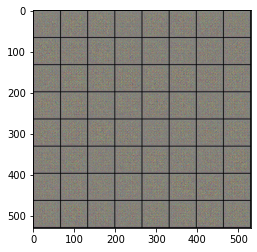

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

In [ ]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(batch_size, noise_size)).cuda()
  text_embeddings = convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

In [ ]:
class Concat_embed(nn.Module):

    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
            nn.BatchNorm1d(num_features=projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat

In [ ]:
class Discriminator(nn.Module):
  '''
  The Discriminator Network
  '''

  def __init__(self):
    super(Discriminator, self).__init__()
    self.image_size = 64
    self.num_channels = 3
    self.embed_dim = 768
    self.projected_embed_dim = 256
    self.ndf = 64
    
    ## Image Encoder 
    self.netD_1 = nn.Sequential(
        # input nc x 64 x 64
        nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        # state size ndf x 32 x 32
        nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(self.ndf * 2),
        nn.LeakyReLU(0.2, inplace = True),

        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),

        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),

    )

    ## Text Encoder
    self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)

    ## Text + Image Concat Layer
    self.netD_2 = nn.Sequential(
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    self.optimD = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.999))

  def forward(self, input_img, text_embeddings):
    x_intermediate = self.netD_1(input_img)
    x = self.projector(x_intermediate, text_emb eddings)
    x = self.netD_2(x)

    return x.view(-1, 1), x_intermediate


In [ ]:
discriminator = Discriminator()
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (projector): Concat_embed(
    (projection): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)

In [ ]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([64, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (projector): Concat_embed(
    (projection): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)

## Specifying loss functions

In [ ]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

## Plotting output after each epoch

In [ ]:
plt_images, plt_labels, fake_img = weighted_dataiter.next()
plt_o_text_embeddings = convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

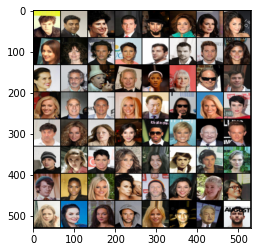

['He has brown and wavy hair. The male is attractive and young.', 'The gentleman looks chubby, has a double chin and pretty high cheekbones. His hair is black and straight. He has a big nose, bushy eyebrows, a slightly open mouth and narrow eyes. He looks young and is smiling. He is wearing a necktie.', 'The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.', 'The gentleman has high cheekbones. His hair is black and wavy. He has bushy eyebrows. He is wearing a necktie.', 'The man is chubby. He grows a goatee. He has arched eyebrows, a big nose and bushy eyebrows. The man seems attractive and young. He is wearing earrings and a hat.', 'The female has pretty high cheekbones. She has wavy hair. She has arched eyebrows, big lips and a slightly open mouth. The lady is smiling and has heavy makeup. She is wearing earrings an

In [ ]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), noise_size)).cuda()

In [ ]:
def plot_output():
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
  
  show_grid(torchvision.utils.make_grid(test_images.cpu(), normalize=True))


## Training

In [ ]:
pbar = tqdm()

for epoch in range(epochs):
  print(f'Epoch:  {epoch + 1} / {epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #converting to cuda
    real_images = real_images.cuda()
    text_embeddings = convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)    
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    ## Training the discriminator
    discriminator.zero_grad()
    output, activation_real = discriminator(real_images, text_embeddings)
    real_loss = criterion(output, smoothed_real_labels)
    real_score = output

    output, _ = discriminator(wrong_images, text_embeddings)
    wrong_loss = criterion(output, fake_validity)

    input_noise = torch.randn(size=(current_batch_size, noise_size)).cuda()
    fake_images = generator(input_noise, text_embeddings)
    output, _ = discriminator(fake_images, text_embeddings)
    fake_loss = criterion(output, fake_validity)

    d_loss = real_loss + wrong_loss + fake_loss

    d_loss.backward()
    discriminator.optimD.step()
    discriminator_loss.append(d_loss)

    ## Training generator
    generator.zero_grad()
    input_noise = torch.randn(size=(current_batch_size, noise_size)).cuda()
    fake_images = generator(input_noise, text_embeddings)
    output, activation_fake = discriminator(fake_images, text_embeddings)
    _, activation_real = discriminator(real_images, text_embeddings)

    activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
    activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

    g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

    g_loss.backward()
    generator.optimG.step()
    generator_loss.append(g_loss)

    pbar.update()

  print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))
  
  if (epoch + 1) % 1 == 0:
    plot_output()

pbar.refresh()




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
generator.eval()
discriminator.eval()  
torch.save(generator.state_dict(), '/content/drive/My Drive/MachineLearning/Incubator/saved_models/GANcls/generator.pt')
torch.save(discriminator.state_dict(), '/content/drive/My Drive/MachineLearning/Incubator/saved_models/GANcls/discriminator.pt')
generator.train()
discriminator.train()  


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (projector): Concat_embed(
    (projection): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)

In [ ]:
test_noise = torch.randn(size=(1, noise_size)).cuda()
test_embeddings = convert_text_to_embeddings(['The man is chubby, has a double chin and pretty high cheekbones. He grows a sideburns. His hair is gray and receding. He has big lips and a big nose. The man looks young.'])

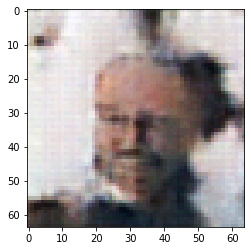

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, noise_size)).cuda()
test_embeddings = convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

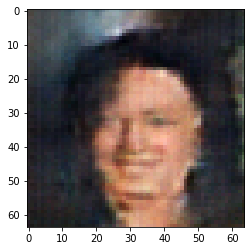

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))